# MNIST Handwritten Digit Classification

This notebook demonstrates a classic classification task using the `clownpiece` library to recognize handwritten digits from the MNIST dataset.

We will:
1.  Load the MNIST dataset using `torchvision`.
2.  Preprocess the data with torch and convert it to `clownpiece` Tensors.
3.  Build and train a simple transformer classifier.
4.  Use `CrossEntropyLoss` for training.
5.  Evaluate the model's accuracy on a test set.

In [1]:
import sys
sys.path.append('../../../')

import math
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch

from clownpiece import Tensor
from clownpiece.autograd import no_grad
from clownpiece.nn import Module, Linear, ReLU, Sequential, CrossEntropyLoss, MultiheadAttention

### Helper Functions

To make the code cleaner and more readable, we define two helper functions. `to_CT_tensor` converts a `torch.Tensor` to a `clownpiece.Tensor`, and `to_numpy` converts a `clownpiece.Tensor` back to a `numpy.ndarray`.

In [2]:
def to_CT_tensor(torch_tensor, requires_grad=False):
    """Converts a torch.Tensor to a clownpiece.Tensor."""
    return Tensor(torch_tensor.numpy().tolist(), requires_grad=requires_grad)

def to_numpy(clownpiece_tensor):
    """Converts a clownpiece.Tensor to a numpy.ndarray."""
    return np.array(clownpiece_tensor.tolist())

### 1. Loading and Preprocessing the Data

We use `torchvision` to load the MNIST dataset. The dataset is transformed into tensors and normalized. We use `torch.utils.data.DataLoader` to create iterators for both the training and test sets, which will feed data to our model in batches.

In [3]:
# Load MNIST dataset using torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

batch_size = 20

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

print("MNIST dataset loaded successfully.")

MNIST dataset loaded successfully.


### 2. Defining the Model Architecture

Our model is a dummy transformer model, which has 
1. A image embedding layer that partition the image into patches, and apply the same linear kernel.
2. A transformer block
3. A reduction operator to squeeze out hidden dimension into singleton
4. A final linear projection into classes.

In [4]:
# Define the model
img_dim = 28
input_features = img_dim ** 2  # 28x28 images flattened

num_classes = 10

hidden_dim = 4
kernel_size = 4

num_patches = (img_dim // kernel_size) ** 2

class ImageEmbedding(Module):
    # split image into (kernel_size x kernel_size) non-interleaving patches and project them to hidden_states
    # if you are familiar with LLM but not ViT, consider: 
    #   patches in CV <=> tokens in NLP 
    #     num_patches <=> sequence_length
    
    def __init__(self, img_dim, hidden_dim, kernel_size = 2):
        super().__init__()
        self.img_dim = img_dim
        self.input_features = img_dim ** 2
        self.kernel_size = kernel_size
        self.patch_size = kernel_size * kernel_size
        
        assert img_dim % kernel_size == 0, "image dimensions must be divisible by kernel_size"
        
        self.num_patches = (img_dim // kernel_size) ** 2
        
        self.kernel = Linear(self.patch_size, hidden_dim)

    # (batch_size, input_features) -> (batch_size, num_patches, hidden_dim)
    def forward(self, x):
        batch_size = x.shape[0]
        img_dim = self.img_dim
        patch_h, patch_w = self.kernel_size, self.kernel_size
        
        # Reshape to (batch_size, H, W) to properly extract patches
        images = x.reshape([batch_size, img_dim, img_dim])
        
        # Create patches
        # (batch_size, num_patches_h, patch_h, num_patches_w, patch_w)
        patches = images.reshape([batch_size, img_dim // patch_h, patch_h, img_dim // patch_w, patch_w])
        # Transpose to (batch_size, num_patches_h, num_patches_w, patch_h, patch_w)
        patches = patches.transpose(2, 3)
        # Reshape to (batch_size, num_patches, patch_size)
        patches = patches.reshape([batch_size, self.num_patches, self.patch_size])
        
        # Project patches to embeddings
        return self.kernel(patches)
    
class TransformerBlock(Module):
    # self-attention + mlp
    
    def __init__(self, hidden_dim, num_heads, ffn_dim):
        super().__init__()
        self.attention = MultiheadAttention(hidden_dim, num_heads, True)
        
        self.mlp = Sequential(
            Linear(hidden_dim, ffn_dim),
            ReLU(),
            Linear(ffn_dim, hidden_dim)
        )

        ## hidden dim is too small to use LayerNorm
        # self.layer_norm1 = LayerNorm(hidden_dim, affine=False)
        # self.layer_norm2 = LayerNorm(hidden_dim, affine=False)

    # (batch_size, num_patches, hidden_dim) -> (batch_size, num_patches, hidden_dim)
    def forward(self, x):
        x = x + self.attention(x)
        # x = self.layer_norm1(x)
        x = x + self.mlp(x)
        # x = self.layer_norm2(x)
        return x
    
class ClampAndReduce(Module): 
    # reduce hidden_dims by mean pooling
    def __init__(self, bound = 2.0):
        super().__init__()
        self.bound = bound
        
    # (batch_size, num_patches, hidden_dim) -> (batch_size, num_patches)
    def forward(self, x): 
        x = x.clamp(-self.bound, self.bound) 
        return x.mean(dim=-1) 

model = Sequential(
    ImageEmbedding(img_dim=img_dim, hidden_dim=hidden_dim, kernel_size=kernel_size),
    ReLU(),
    TransformerBlock(hidden_dim, num_heads=1, ffn_dim=2*hidden_dim),
    ReLU(),
    ClampAndReduce(),
    Linear(num_patches, num_classes)
)

print("Model Architecture:")
print(model)

Model Architecture:
Sequential
  (0):   ImageEmbedding
    (kernel):   Linear(in_features=16, out_features=4, bias=True)
  )
  (1):   ReLU
  (2):   TransformerBlock
    (attention):   MultiheadAttention(hidden_dim=4, num_heads=1, bias=True)
      (q_proj):   Linear(in_features=4, out_features=4, bias=True)
      (k_proj):   Linear(in_features=4, out_features=4, bias=True)
      (v_proj):   Linear(in_features=4, out_features=4, bias=True)
      (out_proj):   Linear(in_features=4, out_features=4, bias=True)
    )
    (mlp):   Sequential
      (0):   Linear(in_features=4, out_features=8, bias=True)
      (1):   ReLU
      (2):   Linear(in_features=8, out_features=4, bias=True)
    )
  )
  (3):   ReLU
  (4):   ClampAndReduce
  (5):   Linear(in_features=49, out_features=10, bias=True)
)


### 3. Training the Model

Here, we set up the training parameters. We use `CrossEntropyLoss` as our loss function, a fixed `learning_rate` of 0.01, and train for 3 epochs. We'll track the training loss and test accuracy during training.

In [5]:
# Loss and training parameters
loss_fn = CrossEntropyLoss()
init_lr = 5e-2
grad_clip = 1.0
epochs = 5

def get_lr(epoch, iter, epochs = epochs, iters_per_epoch = len(train_loader), init_lr = init_lr, final_lr = init_lr / 20):
  # exponential lr scheduler
  total_iter = epochs * iters_per_epoch
  cur_iter = epoch * iters_per_epoch + iter
  beta = math.log(final_lr / init_lr) / total_iter
  return init_lr * math.exp(beta * cur_iter)

train_losses = []
test_accuracies = []

print_iter_interval = 100
earily_stop_interval = 5 # * print_iter_interval

def earily_stop(acc_history, earily_stop_interval = earily_stop_interval) -> bool:
  # return true if accuracy hasn't improved for last earily_stop_interval acc_history
  if len(acc_history) <= earily_stop_interval:
    return False
  max_acc = max(acc_history[:-earily_stop_interval])
  return max_acc >= max(acc_history[-earily_stop_interval:])

The training loop iterates through the dataset for a specified number of epochs. In each iteration (batch), it performs the following steps:
1.  **Forward Pass**: Computes the model's predictions (logits).
2.  **Loss Calculation**: Measures the difference between predictions and actual labels.
3.  **Backward Pass**: Computes gradients of the loss with respect to model parameters.
4.  **Weight Update**: Adjusts model weights using gradient descent.
5.  **Zero Gradients**: Resets gradients for the next iteration.

> HINT: Model performance may improve slowly or even decrease in first few iterations; do not terminate so eargerly. You may rely on the earily stopping.

In [6]:
# Training loop
# May take up to ~10 minutes
def train():
    model.train()
    for epoch in range(epochs):
        print(f">> Epoch {epoch+1:2}/{epochs}, Lr: {get_lr(epoch, 0):.6f}")
        sum_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            # Flatten the data and convert to clownpiece Tensors
            X = to_CT_tensor(data)
            y = to_CT_tensor(target, requires_grad=False)

            # Forward pass
            logits = model(X)

            # Calculate loss
            loss = loss_fn(logits, y)
            sum_loss += loss.item()
            
            if math.isnan(loss.item()):
                print(f"<<Training stopped: NaN loss encountered at epoch {epoch}, batch {batch_idx}.\n")
                return

            # Backward pass
            loss.backward()

            # Update weights
            with no_grad():
                lr = get_lr(epoch, batch_idx)
                for param in model.parameters():
                    if param.grad is not None:
                        grad = param.grad.clamp(-grad_clip, grad_clip)  # Gradient clipping for stability
                        param.copy_(param - grad * lr)
            
            # Zero gradients
            for param in model.parameters():
                if param.grad is not None:
                    param.grad = None
            
            if batch_idx % print_iter_interval == 0:
                avg_loss = sum_loss / (batch_idx + 1)
                train_losses.append(avg_loss)
                # Evaluation on test set
                model.eval()
                correct = 0
                with no_grad():
                    for test_data, test_target in test_loader:
                        test_data_flat = test_data.view(test_data.shape[0], -1)
                        X_test = to_CT_tensor(test_data_flat)
                        
                        logits_test = model(X_test)
                        pred = np.argmax(to_numpy(logits_test), axis=1)
                        correct += np.sum(pred == test_target.numpy())
                
                accuracy = 100. * correct / len(test_loader.dataset)
                test_accuracies.append(accuracy)
                
                print(f'Train Epoch: {epoch + 1} [{batch_idx * len(data)}/{len(train_loader.dataset)}]\tLoss: {avg_loss:.6f}, Accuracy: {accuracy:.2f}%', flush=True)
                model.train() # Switch back to train mode
                
                if earily_stop(acc_history=test_accuracies):
                    print(f"<<Training completed: Earily stopped")
                    return
                
    print("<<Training completed: Target epochs reached")
    return
train()

>> Epoch  1/5, Lr: 0.050000
Train Epoch: 1 [0/60000]	Loss: 2.268403, Accuracy: 9.13%
Train Epoch: 1 [2000/60000]	Loss: 2.303175, Accuracy: 16.61%
Train Epoch: 1 [4000/60000]	Loss: 2.271466, Accuracy: 35.95%
Train Epoch: 1 [6000/60000]	Loss: 2.106521, Accuracy: 68.72%
Train Epoch: 1 [8000/60000]	Loss: 1.899457, Accuracy: 74.39%
Train Epoch: 1 [10000/60000]	Loss: 1.731375, Accuracy: 77.16%
Train Epoch: 1 [12000/60000]	Loss: 1.603280, Accuracy: 77.47%
Train Epoch: 1 [14000/60000]	Loss: 1.498248, Accuracy: 77.90%
Train Epoch: 1 [16000/60000]	Loss: 1.417899, Accuracy: 79.41%
Train Epoch: 1 [18000/60000]	Loss: 1.350175, Accuracy: 80.03%
Train Epoch: 1 [20000/60000]	Loss: 1.291158, Accuracy: 80.47%
Train Epoch: 1 [22000/60000]	Loss: 1.244895, Accuracy: 81.05%
Train Epoch: 1 [24000/60000]	Loss: 1.201618, Accuracy: 81.03%
Train Epoch: 1 [26000/60000]	Loss: 1.163502, Accuracy: 81.55%
Train Epoch: 1 [28000/60000]	Loss: 1.130003, Accuracy: 82.10%
Train Epoch: 1 [30000/60000]	Loss: 1.099488, Accura

### 4. Visualizing the Results

Finally, we plot the training loss and test accuracy over the course of training. The x-axis for both plots represents the number of iterations (controlled by `print_iter_interval`), allowing us to see how both metrics evolved as the model processed more data.

Max test accuracy achieved: 86.69%


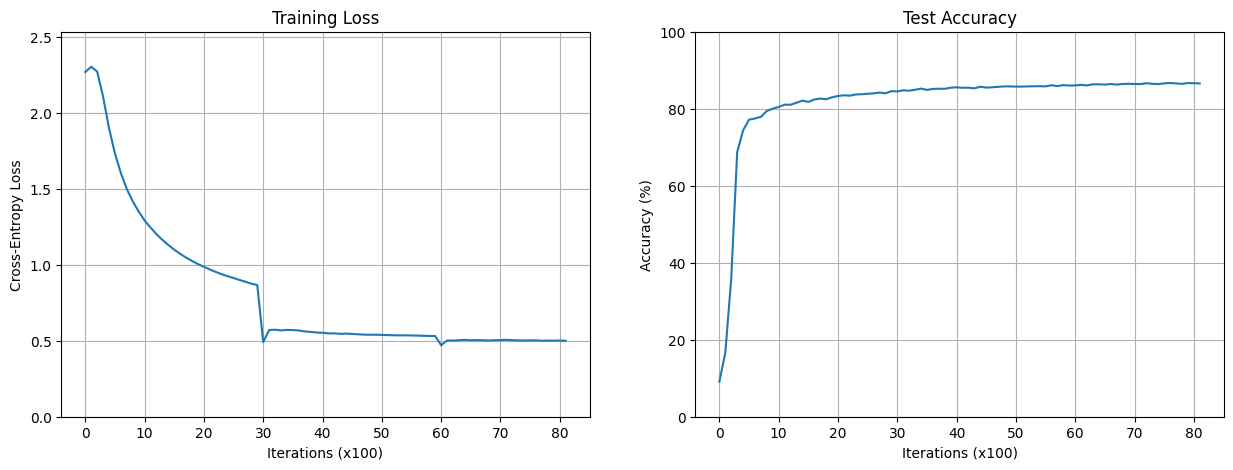

In [7]:
# Plotting results
print(f"Max test accuracy achieved: {max(test_accuracies):.2f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses)
ax1.set_title("Training Loss")
ax1.set_xlabel(f"Iterations (x{print_iter_interval})")
ax1.set_ylabel("Cross-Entropy Loss")
ax1.set_ylim(0, max(train_losses) * 1.1)  # Set y-axis limit to 10% above max loss
ax1.grid(True)

ax2.plot(test_accuracies)
ax2.set_title("Test Accuracy")
ax2.set_xlabel(f"Iterations (x{print_iter_interval})")
ax2.set_ylabel("Accuracy (%)")
ax2.set_ylim(0, 100)
ax2.grid(True)

plt.show()

##### If everything works correctly, you will get an accuracy of around 85% at the end of epoch 1, and stop around that accuracy.

---

# Exploratory Task

### A
In fact, MNIST is a very simple classifiction task: even simple MLP model (like the one in estate_value_predict) can achieve high accuracy.

**Make a copy of this notebook**, then replace the model section to MLP:
- decide intermediate dimension size and number of layers; 
- use a linear layer at last to project hidden states to num_class logits).

Try if it acts even better than the dummy transformer model.

### B

You may wonder why TAs add gradient clipping, test if loss is NaN, and use a small batch size. The numerical stability of this model is prettey bad, and easily explodes.

Try to:
- change batch size
- change learning rate, or remove lr scheduling
- change or remove gradient clipping

How are their effects on the convergence speed and numerical stability, and which is most sensitive?

> These tasks are not graded.
